<div style="position: relative; text-align: center; color: white; height: 300px; overflow: hidden;"">
  <img src="https://images.unsplash.com/photo-1646980990815-1e97d5ee932f?q=80&w=2100&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="Background" style="width: 100%; opacity: 0.3;">
  <div style="position: absolute; top: 40%; left: 25%; transform: translate(-50%, -50%); text-align: center">
    <h1 style="font-weight: bold;">RiceDetection | CNN using TF & Keeas</h1>
  </div>
</div>

**Hi!**

In this project we use [Rice image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset) for rice categorization with **CNN** architecure using **TensorFlow & Keras** API.

Hope you enjoy and support this notebook!

# Importing Libs.

In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout,BatchNormalization
from keras.models import Model, Sequential
from tensorflow.keras import callbacks
from keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import imageio
import matplotlib.image as img
import pathlib
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  7 14:39:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:02<00:00, 87.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [4]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [5]:
import os
path = "/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1"
print(os.listdir(path))


['Rice_Image_Dataset']


In [6]:
subdir_path = os.path.join(path, 'Rice_Image_Dataset')
print(os.listdir(subdir_path))


['Jasmine', 'Rice_Citation_Request.txt', 'Arborio', 'Basmati', 'Karacadag', 'Ipsala']


In [7]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train = train_gen.flow_from_directory(
    "/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val = train_gen.flow_from_directory(
    "/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)


Found 52500 images belonging to 5 classes.
Found 22500 images belonging to 5 classes.


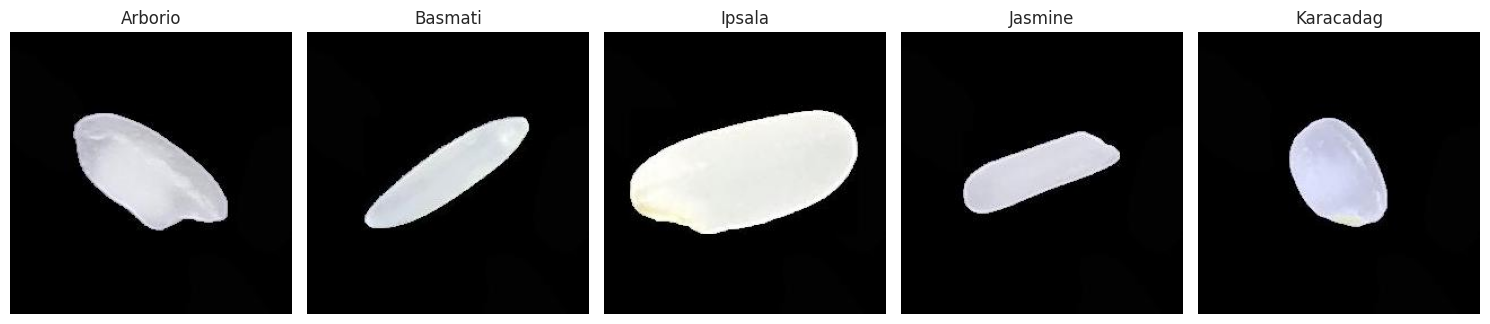

In [8]:
import os
import matplotlib.pyplot as plt
import cv2

def plot_images_from_dataset(base_path):
    """
    Plots one image from each class in a dataset where classes are subfolders.

    Parameters:
    - base_path (str): The path to the root directory containing class subfolders.
    """
    # Filter only directories (class folders)
    class_names = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]
    class_names = sorted(class_names)  # Sort for consistent order
    num_classes = len(class_names)

    # Create a horizontal subplot
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(base_path, class_name)

        # Get the first image from this class
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not image_files:
            print(f"No images found in class folder: {class_name}")
            continue

        image_path = os.path.join(class_path, image_files[0])  # Take the first image

        # Read and resize the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis("off")  # Hide axes
        axes[i].set_title(class_name)  # Class name as title

    plt.tight_layout()
    plt.show()

# Example Usage:
dataset_path = "/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset"
plot_images_from_dataset(dataset_path)


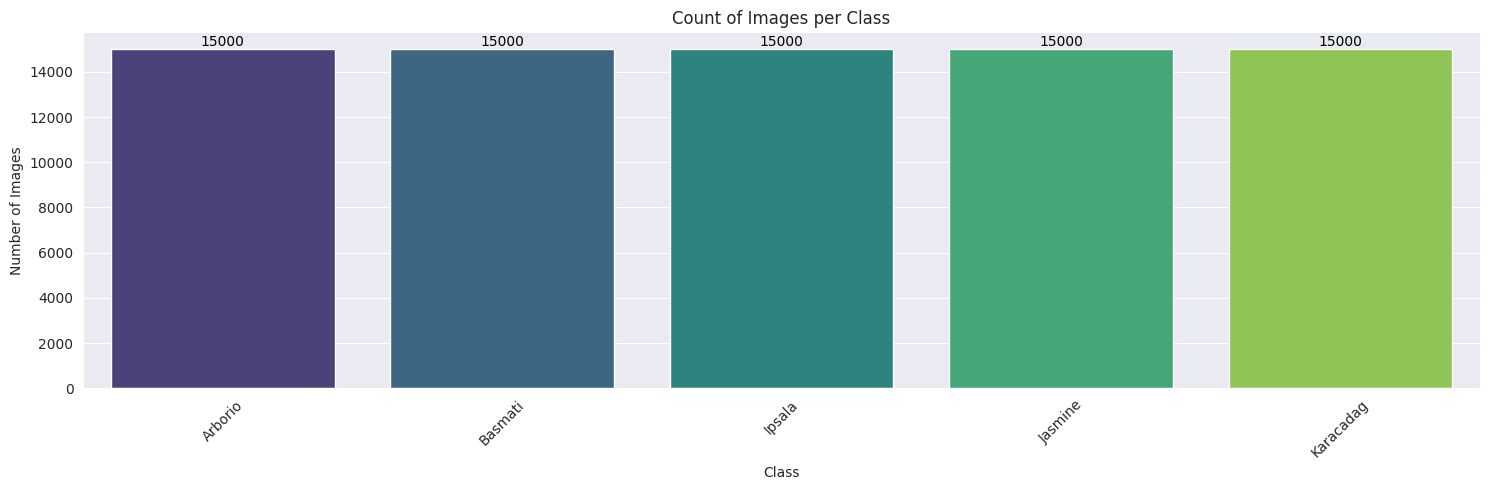

In [9]:
def plot_class_counts_with_annotations(base_path):
    """
    Plots a count plot of the number of images in each class and annotates the counts on each bar.

    Parameters:
    - base_path (str): The path to the root directory containing class subfolders.
    """
    # Get class folders
    class_names = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]
    class_names = sorted(class_names)  # Sort for consistent order

    # Count the number of images in each class
    class_counts = {}
    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        class_counts[class_name] = len(image_files)

    # Convert counts to a Pandas DataFrame for easy plotting
    class_counts_df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

    # Set figure size
    plt.figure(figsize=(15, 5))

    # Plot the count plot
    ax = sns.barplot(data=class_counts_df, x="Class", y="Count", palette="viridis")
    plt.title("Count of Images per Class")
    plt.xticks(rotation=45)  # Rotate class names for readability
    plt.xlabel("Class")
    plt.ylabel("Number of Images")

    # Annotate counts on the bars
    for bar in ax.patches:
        count = int(bar.get_height())  # Get bar height (count)
        ax.annotate(f'{count}',            # Text to annotate
                    (bar.get_x() + bar.get_width() / 2, count),  # Position
                    ha='center', va='bottom', fontsize=10, color='black')  # Styling

    plt.tight_layout()
    plt.show()

# Example Usage:
dataset_path = "/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset"
plot_class_counts_with_annotations(dataset_path)


In [10]:
print("Train class names: ", train.class_indices.keys())
print("Validation class names: ", val.class_indices.keys())

Train class names:  dict_keys(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
Validation class names:  dict_keys(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])


In [11]:
class BaseModel:
    def __init__(self, input_shape=(224, 224, 3), num_classes=5):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def Model(self):
        model = Sequential([
            # First Convolutional Block
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            # Second Convolutional Block
            tf.keras.layers.Conv2D(64, (3, 3), activation='swish', kernel_regularizer=l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(0.2),


            # Third Convolutional Block
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # Flatten the output
            tf.keras.layers.Flatten(),

            # Fully Connected Layers
            tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])
        return model


class AverageAccuracyCheckpoint(Callback):
    def __init__(self, filepath, save_best_only=True, mode="max"):
        super(AverageAccuracyCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.mode = mode
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get("accuracy")  # Training accuracy
        val_acc = logs.get("val_accuracy")  # Validation accuracy

        if train_acc is not None and val_acc is not None:
            avg_accuracy = (train_acc + val_acc) / 2.0
            logs["avg_accuracy"] = avg_accuracy  # Add average accuracy to logs
            print(f"Epoch {epoch + 1}: avg_accuracy = {avg_accuracy:.4f}")

            if self.save_best_only:
                if (self.mode == "max" and avg_accuracy > self.best) or \
                   (self.mode == "min" and avg_accuracy < self.best):
                    self.best = avg_accuracy
                    self.model.save(self.filepath)
                    print(f"Model saved at {self.filepath}")
            else:
                self.model.save(self.filepath)


class CallbackHandler:
    def __init__(self, checkpoint_path="best_model.keras"):
        self.checkpoint_path = checkpoint_path

    def get_callbacks(self):
        avg_acc_checkpoint = AverageAccuracyCheckpoint(
            filepath=self.checkpoint_path,
            save_best_only=True,
            mode="max"
        )
        return [avg_acc_checkpoint]


class Trainer:
    def __init__(self, model, callbacks):
        self.model = model
        self.callbacks = callbacks

    def compile_model(self, learning_rate=0.001):
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def Train(self, train_data, val_data, epochs, batch_size):
        return self.model.fit(
            train_data,
            validation_data=val_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=self.callbacks
        )


# Build the model
base_model = BaseModel()
model = base_model.Model()

# Get callbacks
callback_handler = CallbackHandler()
callbacks = callback_handler.get_callbacks()

# Compile and train the model
trainer = Trainer(model=model, callbacks=callbacks)
trainer.compile_model(learning_rate=0.001)

# Check the model summary
model.summary()

# Example usage
# trainer.Train(train_data, val_data, epochs=10, batch_size=32)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,629 (42.61 MB)

 Trainable params: 11,170,117 (42.61 MB)

 Non-trainable params: 512 (2.00 KB)

In [12]:
history = trainer.Train(train, val, epochs=20, batch_size=32)

Epoch 1/20
1639/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9305 - loss: 1.7228Epoch 1: avg_accuracy = 0.9414
Model saved at best_model.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 104s 57ms/step - accuracy: 0.9305 - loss: 1.7211 - val_accuracy: 0.9246 - val_loss: 0.4078 - avg_accuracy: 0.9414
Epoch 2/20
1639/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9687 - loss: 0.3543Epoch 2: avg_accuracy = 0.9507
Model saved at best_model.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 87s 53ms/step - accuracy: 0.9688 - loss: 0.3542 - val_accuracy: 0.9299 - val_loss: 0.5663 - avg_accuracy: 0.9507
Epoch 3/20
1638/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9772 - loss: 0.2556Epoch 3: avg_accuracy = 0.9414
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 85s 52ms/step - accuracy: 0.9772 - loss: 0.2555 - val_accuracy: 0.9052 - val_loss: 0.4230 - avg_accuracy: 0.9414
Epoch 4/20
1638/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9800 - loss: 0.1477Epoch 4: avg_accuracy = 0.9563
Model saved at best_model.k

In [13]:
TLmodel = history.history['loss']
VLmodel = history.history['val_loss']
TAmodel = history.history['accuracy']
VAmodel = history.history['val_accuracy']

In [14]:

import plotly.express as px

# Example data
epochs = range(1, len(TAmodel) + 1)

# Create a DataFrame for Plotly
data = {
    "Epoch": list(epochs) * 2,
    "Accuracy": list(TAmodel) + list(VAmodel),
    "Type": ["Training ACC"] * len(epochs) + ["Validation ACC"] * len(epochs)
}

df = pd.DataFrame(data)

# Create the plot using plotly.express
fig = px.line(
    df,
    x="Epoch",
    y="Accuracy",
    color="Type",
    line_dash="Type",  # Different line styles for different types
    markers=True,
    title="Number of epochs & ACC in model ",
    labels={"Accuracy": "ACC", "Epoch": "Epoch"},
    template="plotly_dark"  # Apply the dark template
)

# Customize the colors
fig.update_traces(
    line=dict(width=2.5),
    marker=dict(size=6)
)

# Show the plot
fig.show()



In [15]:

import plotly.express as px

# Example data
epochs = range(1, len(TAmodel) + 1)

# Create a DataFrame for Plotly
data = {
    "Epoch": list(epochs) * 2,
    "Accuracy": list(TLmodel) + list(VLmodel),
    "Type": ["Training Loss"] * len(epochs) + ["Validation loss"] * len(epochs)
}

df = pd.DataFrame(data)

# Create the plot using plotly.express
fig = px.line(
    df,
    x="Epoch",
    y="Accuracy",
    color="Type",
    line_dash="Type",  # Different line styles for different types
    markers=True,
    title="Number of epochs & Loss in model ",
    labels={"Accuracy": "Loss", "Epoch": "Epoch"},
    template="plotly_dark"  # Apply the dark template
)

# Customize the colors
fig.update_traces(
    line=dict(width=2.5),
    marker=dict(size=6)
)

# Show the plot
fig.show()



In [18]:
class_names = list(train.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [19]:
# Predict on training data
train_steps = len(train)
y_pred_train = np.argmax(model.predict(train, steps=train_steps), axis=1)  # Predicted labels
y_true_train = train.classes  # True labels from the generator

# Predict on validation data
val_steps = len(val)
y_pred_val = np.argmax(model.predict(val, steps=val_steps), axis=1)  # Predicted labels
y_true_val = val.classes  # True labels from the generator


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step


In [25]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - class_names: List of class names.
    - title: Title for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


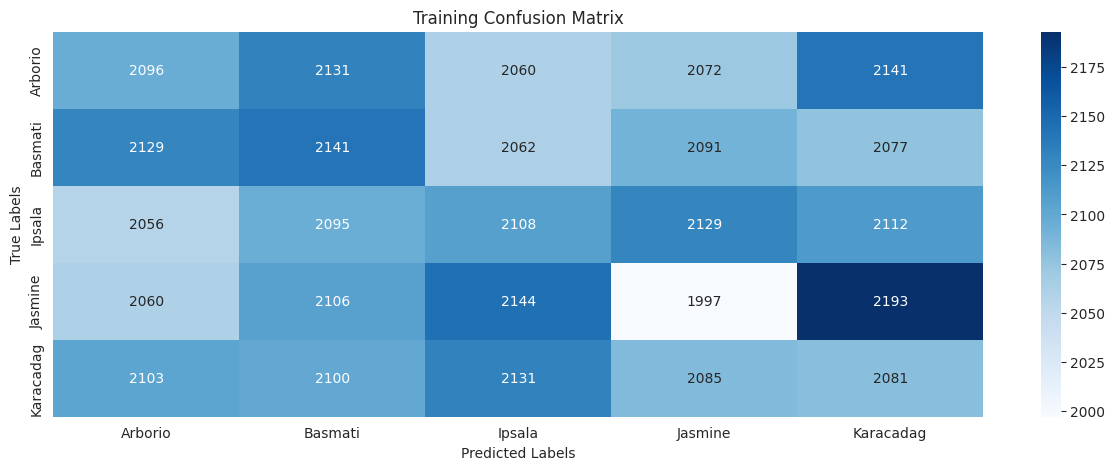

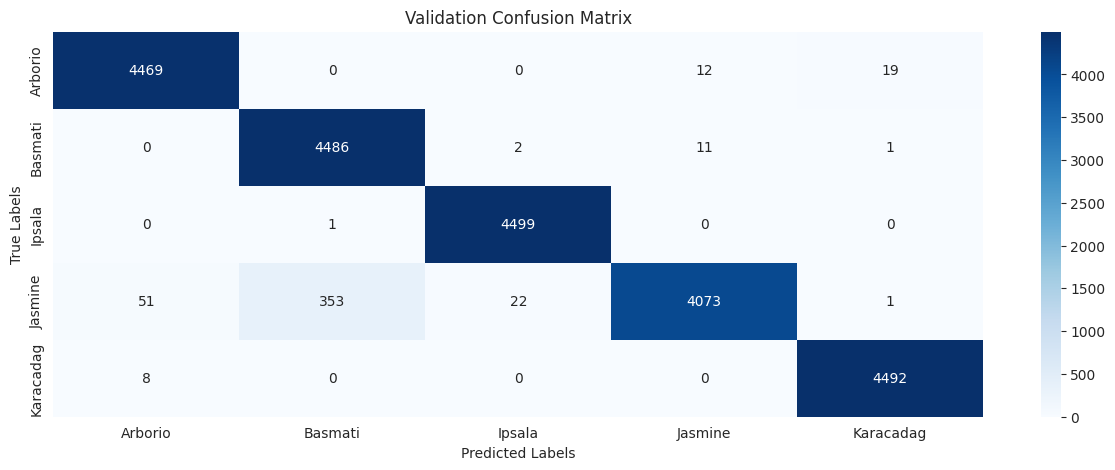

In [26]:
plot_confusion_matrix(y_true_train, y_pred_train, class_names, title="Training Confusion Matrix")
plot_confusion_matrix(y_true_val, y_pred_val, class_names, title="Validation Confusion Matrix")


In [28]:
from sklearn.metrics import classification_report

def print_evaluation_metrics(y_true, y_pred, class_names):
    """
    Prints a classification report with precision, recall, F1-score, and support for each class.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - class_names: List of class names.
    """
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Model Evaluation Metrics:\n")
    print(report)

# Training Metrics
print("Training Metrics:")
print_evaluation_metrics(y_true_train, y_pred_train, class_names)

# Validation Metrics
print("\nValidation Metrics:")
print_evaluation_metrics(y_true_val, y_pred_val, class_names)


Training Metrics:
Model Evaluation Metrics:

              precision    recall  f1-score   support

     Arborio       0.20      0.20      0.20     10500
     Basmati       0.20      0.20      0.20     10500
      Ipsala       0.20      0.20      0.20     10500
     Jasmine       0.19      0.19      0.19     10500
   Karacadag       0.20      0.20      0.20     10500

    accuracy                           0.20     52500
   macro avg       0.20      0.20      0.20     52500
weighted avg       0.20      0.20      0.20     52500


Validation Metrics:
Model Evaluation Metrics:

              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      4500
     Basmati       0.93      1.00      0.96      4500
      Ipsala       0.99      1.00      1.00      4500
     Jasmine       0.99      0.91      0.95      4500
   Karacadag       1.00      1.00      1.00      4500

    accuracy                           0.98     22500
   macro avg       0.98      0.98     